In [1]:
import numpy as np
from numpy import inf
import matplotlib.pyplot as plt
import glob
import torch
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

In [ ]:
#Please decomment these two command lines if the nbimporter library is not installed
#!pip install nbimporter

In [2]:
import sys
import nbimporter
import PWLR_Embedding as PWLR
import warnings
warnings.filterwarnings('ignore')

# Classification Functions

In [3]:
#Load graph labels
def load_index(name):
    index_set = []
    with open("data/"+name+"/Labels.txt") as f:
        for line in f:
            if line[-2:] == "\n":
                index_set += [int(line[:-2])]
            else:
                index_set += [int(line)]
    index_set = np.array(index_set)
    return index_set

#Classification with Grid Search
def classifier_model(x_data, y_data,SKF, N_JOBS, CV, PARAMS, classifier_type='rf'):
    total_acc=[]
    for train_idx, test_idx in SKF.split(x_data, y_data):
        X_train, X_test = x_data[train_idx], x_data[test_idx]
        y_train, y_test = y_data[train_idx], y_data[test_idx]            
        rf=RandomForestClassifier(random_state = 42)
        grid_cv = GridSearchCV(rf, param_grid=PARAMS, cv=CV, n_jobs=N_JOBS)
        grid_cv.fit(X_train, y_train)
        model=grid_cv.best_estimator_

        pred_y=model.predict(X_test)    
        acc = accuracy_score(y_test, pred_y)
        total_acc+=[acc]
        
    return np.mean(total_acc)

#Classification without Grid Search
def prelim_classifier_model(x_data, y_data,SKF, N_JOBS, PARAMS, classifier_type='rf'):
    total_acc=[]
    for train_idx, test_idx in SKF.split(x_data, y_data):
        X_train, X_test = x_data[train_idx], x_data[test_idx]
        y_train, y_test = y_data[train_idx], y_data[test_idx]            
        rf=RandomForestClassifier(random_state = 42)
        rf.fit(X_train, y_train)
        model=rf
        pred_y=model.predict(X_test)    
        acc = accuracy_score(y_test, pred_y)
        total_acc+=[acc]
    return np.mean(total_acc) 

#Sample feature importance obtained from RF
def classifier_model_feature(dataset_name, entry_type, x_data, y_data,SKF, N_JOBS, CV, PARAMS, classifier_type='rf'):
    total_acc=[]
    i = 0
    for train_idx, test_idx in SKF.split(x_data, y_data):
        i += 1
        if i > 1:
            continue

        X_train, X_test = x_data[train_idx], x_data[test_idx]
        y_train, y_test = y_data[train_idx], y_data[test_idx]            
        rf=RandomForestClassifier(random_state = 42)
        rf.fit(X_train, y_train)
        model=rf
        
        pred_y=model.predict(X_test)    
        acc = accuracy_score(y_test, pred_y)
        total_acc+=[acc]
        
        #extract feature importance
        feature = model.feature_importances_
        m_list = []
        a_list = PWLR.GraphDataset(dataset_name)
        edge_list = a_list.get_edge_degree_list()
        for entry in edge_list:
            m_list += [str((entry[0],entry[1]))]
        
        #arrange histogram in descending order
        print("---Feature Importance---")
        histogram = []
        for index in range(0,len(m_list)):
            entry = [m_list[index],feature[index]]
            print(entry)
            histogram += [entry]
        histogram.sort(key=lambda x: x[1])
        
        #draw histogram
        m_list = []
        feature = []
        for index in range(0,len(histogram)):
            m_list += [histogram[index][0]]
            feature += [histogram[index][1]]
        
        fig, ax = plt.subplots(figsize=(len(m_list)/2,len(m_list)/4))
        ax.barh(m_list, feature, align='center')
        ax.set_title(dataset_name+":H"+str(entry_type))
        ax.set_xlabel('Feature Importance')
        ax.set_ylabel('Edge Tuples')
        labels = ax.get_yticklabels()
        labels[-1].set_fontweight('bold')
        plt.show()
        
        return 0

In [4]:
def grid_search_graph(name, entry_type, parameter_list, repeat_num, n_estimator_list, max_depth_list, data_type='Discrete', classifier_type='rf', embed_type=1, grid_check=True, feature_check=True):
    if data_type == 'Discrete':
        HH0=np.load("embed/"+name+f"_discrete_component_seq_30_30_ver{embed_type}.npy")
        HH1=np.load("embed/"+name+f"_discrete_cycle_seq_30_30_ver{embed_type}.npy")
    elif data_type == 'Continuous':
        HH0=np.load("embed/"+name+f"_component_seq_30_30_ver{embed_type}.npy")
        HH1=np.load("embed/"+name+f"_cycle_seq_30_30_ver{embed_type}.npy")
    else:
        HH0=np.load("embed/"+name+f"_no_label_component_seq_30_30_ver{embed_type}.npy")
        HH1=np.load("embed/"+name+f"_no_label_cycle_seq_30_30_ver{embed_type}.npy")        
            
    YY=load_index(name)
    
    #Preprocess any vector entries padded with np.inf or -np.inf values
    HH0[HH0==-inf]=-1
    HH1[HH1==-inf]=-1
    HH0[HH0==inf]=+1000
    HH1[HH1==inf]=+1000    
    HH0=HH0+1
    HH1=HH1+1
    
    #Concatenate results
    test_step_matrix=[]    
    HH2=np.concatenate((HH0,HH1),3)
    test_step1=HH0.shape[1]
    test_step2=HH0.shape[2]
    for i in range(test_step1):
        for j in range(test_step2):
            _test=[i,j]
            test_step_matrix.append(_test)
    
    if classifier_type=='rf':
        params ={
            'n_estimators':n_estimator_list,
            'max_depth':max_depth_list
        }
    elif classifier_type=='svc':
        params ={
        'C': [0.1,1,10,50]
        }
        
        
    repeat=repeat_num
    n_jobs=8
    
    ALL_ACC0=[]
    ALL_ACC1=[]
    ALL_ACC2=[]
    for k1,k2 in test_step_matrix: 
        if (k1,k2) not in parameter_list:
            continue
        mean_acc_0=[]
        mean_acc_1=[]
        mean_acc_2=[]
        print(f' {k1} and {k2}')
        np.random.seed(42)        
        all_acc0 = [] 
        all_acc1 = [] 
        all_acc2 = [] 
        skf = StratifiedKFold(n_splits=10, shuffle=True)
        if grid_check or feature_check:
            cv=StratifiedKFold(n_splits=5, shuffle=True)
        x_train_0=HH0[:,k1,k2]
        x_train_1=HH1[:,k1,k2]
        x_train_2=HH2[:,k1,k2]
        y_train_0=YY[:]
        y_train_1=YY[:]
        y_train_2=YY[:]
        
        all_acc0=[]
        if entry_type == -1 or entry_type == 0:
            print("---"+str(repeat)+" Iterations of 10-fold CV---")
            for _ in range(repeat):
                if grid_check:
                    mean_acc0=classifier_model(x_train_0, y_train_0, skf, n_jobs, cv, params)
                else:
                    mean_acc0=prelim_classifier_model(x_train_0, y_train_0, skf, n_jobs, params)
                print(mean_acc0)
                all_acc0.append(mean_acc0)
            print("---Results---")
            print('H0',np.mean(all_acc0),np.std(all_acc0))
            if feature_check and entry_type == 0 and embed_type == 2:
                mean_acc0=classifier_model_feature(name, entry_type, x_train_0, y_train_0, skf, n_jobs, cv, params)
        
        all_acc1=[]     
        if entry_type == -1 or entry_type == 1:
            print("---"+str(repeat)+" Iterations of 10-fold CV---")
            for _ in range(repeat):
                if grid_check:
                    mean_acc1=classifier_model(x_train_1, y_train_1, skf,n_jobs, cv, params)
                else:
                    mean_acc1=prelim_classifier_model(x_train_1, y_train_1, skf, n_jobs, params)
                print(mean_acc1)
                all_acc1.append(mean_acc1)    
            print("---Results---")
            print('H1',np.mean(all_acc1),np.std(all_acc1)) 
            if feature_check and entry_type == 1 and embed_type == 2:
                mean_acc1=classifier_model_feature(name, entry_type, x_train_1, y_train_1, skf, n_jobs, cv, params)
        
        all_acc2=[] 
        if entry_type == -1 or entry_type == 2:
            print("---"+str(repeat)+" Iterations of 10-fold CV---")
            for _ in range(repeat):
                if grid_check:
                    mean_acc2=classifier_model(x_train_2, y_train_2, skf,n_jobs, cv, params)
                else:
                    mean_acc2=prelim_classifier_model(x_train_2, y_train_2, skf, n_jobs, params)
                print(mean_acc2)
                all_acc2.append(mean_acc2)    
            print("---Results---")
            print('H0+H1',np.mean(all_acc2),np.std(all_acc2))
        
        ALL_ACC0.append(all_acc0)
        ALL_ACC1.append(all_acc1)
        ALL_ACC2.append(all_acc2)

    return ALL_ACC0,ALL_ACC1,ALL_ACC2 #, information_0, information_1, information_2

In [42]:
def grid_search_graph_exact(HH0, HH1, name, entry_type, repeat_num, n_estimator_list, max_depth_list, data_type='Discrete', classifier_type='rf', embed_type=1, grid_check=True, feature_check=True):
    YY=load_index(name)
    
    #Preprocess any vector entries padded with np.inf or -np.inf values
    HH0[HH0==-inf]=-1
    HH1[HH1==-inf]=-1
    HH0[HH0==inf]=+1000
    HH1[HH1==inf]=+1000    
    HH0=HH0+1
    HH1=HH1+1
    
    #Concatenate results
    test_step_matrix=[]    
    HH2=np.concatenate((HH0,HH1),3)
    test_step1=HH0.shape[1]
    test_step2=HH0.shape[2]
    for i in range(test_step1):
        for j in range(test_step2):
            _test=[i,j]
            test_step_matrix.append(_test)
    
    if classifier_type=='rf':
        params ={
            'n_estimators':n_estimator_list,
            'max_depth':max_depth_list
        }
    elif classifier_type=='svc':
        params ={
        'C': [0.1,1,10,50]
        }
        
        
    repeat=repeat_num
    n_jobs=8
    
    ALL_ACC0=[]
    ALL_ACC1=[]
    ALL_ACC2=[]
    for k1,k2 in test_step_matrix: 
        mean_acc_0=[]
        mean_acc_1=[]
        mean_acc_2=[]
        np.random.seed(42)        
        all_acc0 = [] 
        all_acc1 = [] 
        all_acc2 = [] 
        skf = StratifiedKFold(n_splits=10, shuffle=True)
        if grid_check or feature_check:
            cv=StratifiedKFold(n_splits=5, shuffle=True)
        x_train_0=HH0[:,k1,k2]
        x_train_1=HH1[:,k1,k2]
        x_train_2=HH2[:,k1,k2]
        y_train_0=YY[:]
        y_train_1=YY[:]
        y_train_2=YY[:]
        
        all_acc0=[]
        if entry_type == -1 or entry_type == 0:
            print("---"+str(repeat)+" Iterations of 10-fold CV---")
            for _ in range(repeat):
                if grid_check:
                    mean_acc0=classifier_model(x_train_0, y_train_0, skf, n_jobs, cv, params)
                else:
                    mean_acc0=prelim_classifier_model(x_train_0, y_train_0, skf, n_jobs, params)
                print(mean_acc0)
                all_acc0.append(mean_acc0)
            print("---Results---")
            print('H0',np.mean(all_acc0),np.std(all_acc0))
            if feature_check and entry_type == 0 and embed_type == 2:
                mean_acc0=classifier_model_feature(name, entry_type, x_train_0, y_train_0, skf, n_jobs, cv, params)
        
        all_acc1=[]     
        if entry_type == -1 or entry_type == 1:
            print("---"+str(repeat)+" Iterations of 10-fold CV---")
            for _ in range(repeat):
                if grid_check:
                    mean_acc1=classifier_model(x_train_1, y_train_1, skf,n_jobs, cv, params)
                else:
                    mean_acc1=prelim_classifier_model(x_train_1, y_train_1, skf, n_jobs, params)
                print(mean_acc1)
                all_acc1.append(mean_acc1)    
            print("---Results---")
            print('H1',np.mean(all_acc1),np.std(all_acc1)) 
            if feature_check and entry_type == 1 and embed_type == 2:
                mean_acc1=classifier_model_feature(name, entry_type, x_train_1, y_train_1, skf, n_jobs, cv, params)
        
        all_acc2=[] 
        if entry_type == -1 or entry_type == 2:
            print("---"+str(repeat)+" Iterations of 10-fold CV---")
            for _ in range(repeat):
                if grid_check:
                    mean_acc2=classifier_model(x_train_2, y_train_2, skf,n_jobs, cv, params)
                else:
                    mean_acc2=prelim_classifier_model(x_train_2, y_train_2, skf, n_jobs, params)
                print(mean_acc2)
                all_acc2.append(mean_acc2)    
            print("---Results---")
            print('H0+H1',np.mean(all_acc2),np.std(all_acc2))
        
        ALL_ACC0.append(all_acc0)
        ALL_ACC1.append(all_acc1)
        ALL_ACC2.append(all_acc2)

    return ALL_ACC0,ALL_ACC1,ALL_ACC2 #, information_0, information_1, information_2

# Results

### MUTAG - PWLR

In [5]:
name = "MUTAG"
data_type='Discrete'
embed_type=1 #PWLR representation
entry_type=0 #PWLR-H0 representation
n_estimator_list = [10,25,50,100,150,200] #RF n_estimators
max_depth_list = [None]
parameter_list = [(1,12)] #values of k1 and k2
repeat_num=10 #number of iterations of 10-fold CV
grid_type = True #classification result obtained from grid search
feature_type = False #feature importance obtained from RF displayed (only applicable to embed_type=2 & entry_type=0,1)

result0, result1, result2 = grid_search_graph(name, entry_type, parameter_list, repeat_num, n_estimator_list, max_depth_list,data_type=data_type,embed_type=embed_type, grid_check=grid_type, feature_check=feature_type)

 1 and 12
---10 Iterations of 10-fold CV---
0.8992397660818714
0.8883918128654971
0.8873099415204677
0.8937134502923977
0.8803216374269006
0.9100584795321638
0.8884210526315789
0.895029239766082
0.9064327485380117
0.9033918128654973
---Results---
H0 0.8952309941520469 0.008991819502252188


In [6]:
name = "MUTAG"
data_type='Discrete'
embed_type=1 #PWLR representation
entry_type=1 #PWLR-H1 representation
n_estimator_list = [10,25,50,100,150,200] #RF n_estimators
max_depth_list = [None]
parameter_list = [(26,27)] #values of k1 and k2
repeat_num=10 #number of iterations of 10-fold CV
grid_type = True #classification result obtained from grid search
feature_type = False #feature importance obtained from RF displayed (only applicable to embed_type=2 & entry_type=0,1)

result0, result1, result2 = grid_search_graph(name, entry_type, parameter_list, repeat_num, n_estimator_list, max_depth_list,data_type=data_type,embed_type=embed_type, grid_check=grid_type, feature_check=feature_type)

 26 and 27
---10 Iterations of 10-fold CV---
0.9153801169590643
0.9209064327485381
0.9047953216374269
0.9042690058479532
0.9239181286549709
0.9303216374269005
0.9311403508771929
0.9155847953216375
0.9217251461988305
0.9289181286549706
---Results---
H1 0.9196959064327487 0.009208067990877299


In [7]:
name = "MUTAG"
data_type='Discrete'
embed_type=1 #PWLR representation
entry_type=2 #PWLR-H0+H1 representation
n_estimator_list = [10,25,50,100,150,200] #RF n_estimators
max_depth_list = [None]
parameter_list = [(8,11)] #values of k1 and k2
repeat_num=10 #number of iterations of 10-fold CV
grid_type = True #classification result obtained from grid search
feature_type = False #feature importance obtained from RF displayed (only applicable to embed_type=2 & entry_type=0,1)

result0, result1, result2 = grid_search_graph(name, entry_type, parameter_list, repeat_num, n_estimator_list, max_depth_list,data_type=data_type,embed_type=embed_type, grid_check=grid_type, feature_check=feature_type)

 8 and 11
---10 Iterations of 10-fold CV---
0.9100877192982457
0.8997953216374268
0.8611988304093566
0.8937134502923977
0.8966959064327487
0.898684210526316
0.8723099415204679
0.900029239766082
0.9117251461988305
0.9028362573099414
---Results---
H0+H1 0.8947076023391813 0.01513827153744482


### MUTAG - PWLR-OPT

 1 and 1
---10 Iterations of 10-fold CV---
0.8939766081871345
0.8878070175438598
0.9078362573099416
0.8887134502923978
0.9083333333333334
0.8761695906432749
0.9042397660818713
0.8989181286549709
0.8992105263157895
0.9081286549707602
---Results---
H0 0.8973333333333334 0.010128224468519445
---Feature Importance---
['(1, 2)', 0.038033491049206426]
['(1, 3)', 0.11146833814048915]
['(1, 4)', 0.0]
['(2, 2)', 0.1718711511818212]
['(2, 3)', 0.18684952777251734]
['(3, 3)', 0.4917774918559658]
['(3, 4)', 0.0]


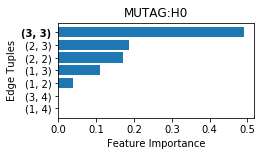

In [8]:
name = "MUTAG"
data_type='Discrete'
embed_type=2 #PWLR-OPT representation
entry_type=0 #PWLR-OPT-H0 representation
n_estimator_list = [10,25,50,100,150,200] #RF n_estimators
max_depth_list = [None]
parameter_list = [(1,1)] #values of k1 and k2
repeat_num=10 #number of iterations of 10-fold CV
grid_type = True #classification result obtained from grid search
feature_type = True #feature importance obtained from RF displayed (only applicable to embed_type=2 & entry_type=0,1)

result0, result1, result2 = grid_search_graph(name, entry_type, parameter_list, repeat_num, n_estimator_list, max_depth_list,data_type=data_type,embed_type=embed_type, grid_check=grid_type, feature_check=feature_type)

 16 and 27
---10 Iterations of 10-fold CV---
0.9264912280701754
0.9314327485380117
0.8826023391812864
0.9089473684210526
0.9039181286549708
0.9197953216374269
0.9302923976608188
0.9150292397660819
0.9375438596491229
0.9344736842105263
---Results---
H1 0.9190526315789475 0.016097202686764327
---Feature Importance---
['(1, 2)', 0.0]
['(1, 3)', 0.0]
['(1, 4)', 0.0]
['(2, 2)', 0.0]
['(2, 3)', 0.926582549757418]
['(3, 3)', 0.07341745024258198]
['(3, 4)', 0.0]


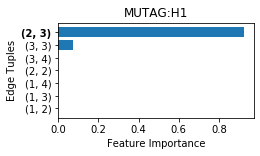

In [9]:
name = "MUTAG"
data_type='Discrete'
embed_type=2 #PWLR-OPT representation
entry_type=1 #PWLR-OPT-H1 representation
n_estimator_list = [10,25,50,100,150,200] #RF n_estimators
max_depth_list = [None]
parameter_list = [(16,27)] #values of k1 and k2
repeat_num=10 #number of iterations of 10-fold CV
grid_type = True #classification result obtained from grid search
feature_type = True #feature importance obtained from RF displayed (only applicable to embed_type=2 & entry_type=0,1)

result0, result1, result2 = grid_search_graph(name, entry_type, parameter_list, repeat_num, n_estimator_list, max_depth_list,data_type=data_type,embed_type=embed_type, grid_check=grid_type, feature_check=feature_type)

In [10]:
name = "MUTAG"
data_type='Discrete'
embed_type=2 #PWLR-OPT representation
entry_type=2 #PWLR-OPT-H0+H1 representation
n_estimator_list = [10,25,50,100,150,200] #RF n_estimators
max_depth_list = [None]
parameter_list = [(1,1)] #values of k1 and k2
repeat_num=10 #number of iterations of 10-fold CV
grid_type = True #classification result obtained from grid search
feature_type = False #feature importance obtained from RF displayed (only applicable to embed_type=2 & entry_type=0,1)

result0, result1, result2 = grid_search_graph(name, entry_type, parameter_list, repeat_num, n_estimator_list, max_depth_list,data_type=data_type,embed_type=embed_type, grid_check=grid_type, feature_check=feature_type)

 1 and 1
---10 Iterations of 10-fold CV---
0.8779239766081872
0.8930994152046784
0.9039473684210527
0.8784502923976609
0.8875438596491227
0.892543859649123
0.8936842105263159
0.9044736842105264
0.8942397660818713
0.8914619883040936
---Results---
H0+H1 0.8917368421052633 0.008419460538257496


# PTC_FR

### PTC_FR PWLR

In [12]:
name = "PTC_FR"
data_type='Discrete'
embed_type=1 #PWLR representation
entry_type=0 #PWLR-H0 representation
n_estimator_list = [10,25,50,100,150,200] #RF n_estimators
max_depth_list = [None]
parameter_list = [(22,8)] #values of k1 and k2
repeat_num=10 #number of iterations of 10-fold CV
grid_type = True #classification result obtained from grid search
feature_type = False #feature importance obtained from RF displayed (only applicable to embed_type=2 & entry_type=0,1)

result0, result1, result2 = grid_search_graph(name, entry_type, parameter_list, repeat_num, n_estimator_list, max_depth_list,data_type=data_type,embed_type=embed_type, grid_check=grid_type, feature_check=feature_type)

 22 and 8
---10 Iterations of 10-fold CV---
0.6863492063492064
0.6725396825396825
0.680952380952381
0.7008730158730159
0.6987301587301588
0.7122222222222222
0.6807936507936507
0.6838095238095238
0.7007936507936509
0.6949206349206349
---Results---
H0 0.6911984126984126 0.011566106403381448


In [13]:
name = "PTC_FR"
data_type='Discrete'
embed_type=1 #PWLR representation
entry_type=1 #PWLR-H1 representation
n_estimator_list = [10,25,50,100,150,200] #RF n_estimators
max_depth_list = [None]
parameter_list = [(0,0)] #values of k1 and k2
repeat_num=10 #number of iterations of 10-fold CV
grid_type = True #classification result obtained from grid search
feature_type = False #feature importance obtained from RF displayed (only applicable to embed_type=2 & entry_type=0,1)

result0, result1, result2 = grid_search_graph(name, entry_type, parameter_list, repeat_num, n_estimator_list, max_depth_list,data_type=data_type,embed_type=embed_type, grid_check=grid_type, feature_check=feature_type)

 0 and 0
---10 Iterations of 10-fold CV---
0.6666666666666666
0.6665079365079365
0.6695238095238096
0.6726190476190476
0.6554761904761905
0.6780158730158731
0.680952380952381
0.6751587301587302
0.6694444444444444
0.6696031746031746
---Results---
H1 0.6703968253968254 0.006715992878395236


In [19]:
name = "PTC_FR"
data_type='Discrete'
embed_type=1 #PWLR representation
entry_type=2 #PWLR-H0+H1 representation
n_estimator_list = [10,25,50,100,150,200] #RF n_estimators
max_depth_list = [None]
parameter_list = [(1,14)] #values of k1 and k2
repeat_num=10 #number of iterations of 10-fold CV
grid_type = True #classification result obtained from grid search
feature_type = False #feature importance obtained from RF displayed (only applicable to embed_type=2 & entry_type=0,1)

result0, result1, result2 = grid_search_graph(name, entry_type, parameter_list, repeat_num, n_estimator_list, max_depth_list,data_type=data_type,embed_type=embed_type, grid_check=grid_type, feature_check=feature_type)

 1 and 14
---10 Iterations of 10-fold CV---
0.697936507936508
0.6865873015873015
0.7064285714285715
0.7064285714285714
0.6986507936507937
0.6723015873015873
0.6638095238095238
0.6838888888888889
0.6838095238095238
0.6749206349206349
---Results---
H0+H1 0.6874761904761906 0.013884525391653628


### PTC_FR PWLR-OPT

 0 and 6
---10 Iterations of 10-fold CV---
0.6296825396825396
0.6552380952380952
0.6580158730158729
0.6438095238095238
0.6303174603174604
0.6267460317460317
0.6353968253968253
0.643888888888889
0.6407936507936508
0.6380952380952382
---Results---
H0 0.6401984126984127 0.009936447715218889
---Feature Importance---
['(1, 1)', 0.0]
['(1, 2)', 0.13148398799383504]
['(1, 3)', 0.20517327104872607]
['(1, 4)', 0.06924545464900951]
['(2, 2)', 0.18237830246506195]
['(2, 3)', 0.18897973626080963]
['(2, 4)', 0.024417579504412562]
['(3, 3)', 0.16579023918148553]
['(3, 4)', 0.019206120538993697]
['(4, 4)', 0.013325308357665907]


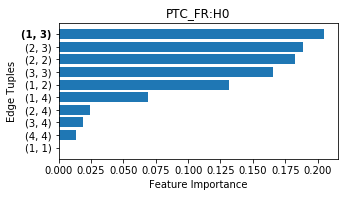

In [16]:
name = "PTC_FR"
data_type='Discrete'
embed_type=2 #PWLR-OPT representation
entry_type=0 #PWLR-OPT-H0 representation
n_estimator_list = [10,25,50,100,150,200] #RF n_estimators
max_depth_list = [None]
parameter_list = [(0,6)] #values of k1 and k2
repeat_num=10 #number of iterations of 10-fold CV
grid_type = True #classification result obtained from grid search
feature_type = True #feature importance obtained from RF displayed (only applicable to embed_type=2 & entry_type=0,1)

result0, result1, result2 = grid_search_graph(name, entry_type, parameter_list, repeat_num, n_estimator_list, max_depth_list,data_type=data_type,embed_type=embed_type, grid_check=grid_type, feature_check=feature_type)

 10 and 2
---10 Iterations of 10-fold CV---
0.6528571428571428
0.6525396825396824
0.6523809523809523
0.6723015873015873
0.6696031746031745
0.6723809523809524
0.6753968253968254
0.6695238095238094
0.6665873015873016
0.6353174603174604
---Results---
H1 0.6618888888888887 0.01227302367402999
---Feature Importance---
['(1, 1)', 0.0]
['(1, 2)', 0.0]
['(1, 3)', 0.0]
['(1, 4)', 0.0]
['(2, 2)', 0.01971726101628929]
['(2, 3)', 0.7736542797773074]
['(2, 4)', 0.0504318200112961]
['(3, 3)', 0.11922725748565441]
['(3, 4)', 0.021672952027309907]
['(4, 4)', 0.01529642968214277]


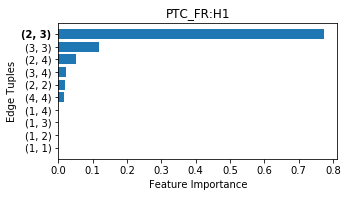

In [15]:
name = "PTC_FR"
data_type='Discrete'
embed_type=2 #PWLR-OPT representation
entry_type=1 #PWLR-OPT-H1 representation
n_estimator_list = [10,25,50,100,150,200] #RF n_estimators
max_depth_list = [None]
parameter_list = [(10,2)] #values of k1 and k2
repeat_num=10 #number of iterations of 10-fold CV
grid_type = True #classification result obtained from grid search
feature_type = True #feature importance obtained from RF displayed (only applicable to embed_type=2 & entry_type=0,1)

result0, result1, result2 = grid_search_graph(name, entry_type, parameter_list, repeat_num, n_estimator_list, max_depth_list,data_type=data_type,embed_type=embed_type, grid_check=grid_type, feature_check=feature_type)

In [17]:
name = "PTC_FR"
data_type='Discrete'
embed_type=2 #PWLR-OPT representation
entry_type=2 #PWLR-OPT-H0+H1 representation
n_estimator_list = [10,25,50,100,150,200] #RF n_estimators
max_depth_list = [None]
parameter_list = [(16,2)] #values of k1 and k2
repeat_num=10 #number of iterations of 10-fold CV
grid_type = True #classification result obtained from grid search
feature_type = False #feature importance obtained from RF displayed (only applicable to embed_type=2 & entry_type=0,1)

result0, result1, result2 = grid_search_graph(name, entry_type, parameter_list, repeat_num, n_estimator_list, max_depth_list,data_type=data_type,embed_type=embed_type, grid_check=grid_type, feature_check=feature_type)

 16 and 2
---10 Iterations of 10-fold CV---
0.6554761904761904
0.661031746031746
0.6496031746031746
0.663968253968254
0.6643650793650793
0.6667460317460318
0.6353174603174603
0.6438095238095237
0.6778571428571429
0.6551587301587302
---Results---
H0+H1 0.6573333333333332 0.011629689809242954


# BZR (Discrete)

### BZR PWLR

In [20]:
name = "BZR"
data_type='Discrete'
embed_type=1 #PWLR representation
entry_type=0 #PWLR-H0 representation
n_estimator_list = [10,25,50,100,150,200] #RF n_estimators
max_depth_list = [None]
parameter_list = [(4,1)] #values of k1 and k2
repeat_num=10 #number of iterations of 10-fold CV
grid_type = True #classification result obtained from grid search
feature_type = False #feature importance obtained from RF displayed (only applicable to embed_type=2 & entry_type=0,1)

result0, result1, result2 = grid_search_graph(name, entry_type, parameter_list, repeat_num, n_estimator_list, max_depth_list,data_type=data_type,embed_type=embed_type, grid_check=grid_type, feature_check=feature_type)

 4 and 1
---10 Iterations of 10-fold CV---
0.8962038774233896
0.9014509068167605
0.8987007504690432
0.90114602876798
0.8919449656035022
0.8911491557223264
0.8933958724202627
0.8938961851156974
0.8966432145090681
0.8741307066916824
---Results---
H0 0.8938661663539712 0.00740174562119186


In [21]:
name = "BZR"
data_type='Discrete'
embed_type=1 #PWLR representation
entry_type=1 #PWLR-H1 representation
n_estimator_list = [10,25,50,100,150,200] #RF n_estimators
max_depth_list = [None]
parameter_list = [(3,4)] #values of k1 and k2
repeat_num=10 #number of iterations of 10-fold CV
grid_type = True #classification result obtained from grid search
feature_type = False #feature importance obtained from RF displayed (only applicable to embed_type=2 & entry_type=0,1)

result0, result1, result2 = grid_search_graph(name, entry_type, parameter_list, repeat_num, n_estimator_list, max_depth_list,data_type=data_type,embed_type=embed_type, grid_check=grid_type, feature_check=feature_type)

 3 and 4
---10 Iterations of 10-fold CV---
0.8888899312070043
0.9039540337711068
0.8836976235146967
0.8985819262038774
0.8988930581613509
0.8962070043777361
0.8936429018136336
0.8915791119449656
0.8917041901188243
0.8815118824265165
---Results---
H1 0.8928661663539714 0.006599225266064187


In [22]:
name = "BZR"
data_type='Discrete'
embed_type=1 #PWLR representation
entry_type=2 #PWLR-H0+H1 representation
n_estimator_list = [10,25,50,100,150,200] #RF n_estimators
max_depth_list = [None]
parameter_list = [(6,1)] #values of k1 and k2
repeat_num=10 #number of iterations of 10-fold CV
grid_type = True #classification result obtained from grid search
feature_type = False #feature importance obtained from RF displayed (only applicable to embed_type=2 & entry_type=0,1)

result0, result1, result2 = grid_search_graph(name, entry_type, parameter_list, repeat_num, n_estimator_list, max_depth_list,data_type=data_type,embed_type=embed_type, grid_check=grid_type, feature_check=feature_type)

 6 and 1
---10 Iterations of 10-fold CV---
0.8863868042526579
0.8915728580362728
0.9011397748592872
0.8938289555972483
0.9041400875547219
0.8861460287679799
0.873947779862414
0.8890791119449656
0.8768167604752971
0.8914509068167605
---Results---
H0+H1 0.8894509068167606 0.008947007482828324


### BZR PWLR-OPT

 2 and 15
---10 Iterations of 10-fold CV---
0.8912617260787993
0.8939477798624141
0.8887007504690432
0.8884537210756724
0.89682301438399
0.8888961851156972
0.9033958724202626
0.9015181363352095
0.9012038774233895
0.8915759849906191
---Results---
H0 0.8945777048155096 0.005473586810716278
---Feature Importance---
['(1, 2)', 0.023303433665172107]
['(1, 3)', 0.1557621130425596]
['(1, 4)', 0.07981152964769904]
['(2, 2)', 0.002772058654245942]
['(2, 3)', 0.11459223810053053]
['(2, 4)', 0.04452007234245443]
['(3, 3)', 0.32529955202472416]
['(3, 4)', 0.20215240222934236]
['(4, 4)', 0.05178660029327203]


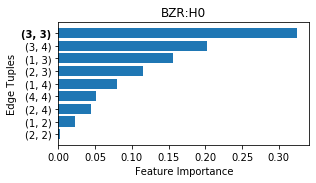

In [23]:
name = "BZR"
data_type='Discrete'
embed_type=2 #PWLR-OPT representation
entry_type=0 #PWLR-OPT-H0 representation
n_estimator_list = [10,25,50,100,150,200] #RF n_estimators
max_depth_list = [None]
parameter_list = [(2,15)] #values of k1 and k2
repeat_num=10 #number of iterations of 10-fold CV
grid_type = True #classification result obtained from grid search
feature_type = True #feature importance obtained from RF displayed (only applicable to embed_type=2 & entry_type=0,1)

result0, result1, result2 = grid_search_graph(name, entry_type, parameter_list, repeat_num, n_estimator_list, max_depth_list,data_type=data_type,embed_type=embed_type, grid_check=grid_type, feature_check=feature_type)

 2 and 0
---10 Iterations of 10-fold CV---
0.901393058161351
0.8890697310819263
0.8986429018136335
0.8885756722951845
0.9013258286429018
0.883707004377736
0.8785756722951845
0.8860178236397749
0.8818871169480925
0.8841979362101314
---Results---
H1 0.8893392745465917 0.007853419958894645
---Feature Importance---
['(1, 2)', 0.0]
['(1, 3)', 0.0]
['(1, 4)', 0.0]
['(2, 2)', 0.0]
['(2, 3)', 0.24074101303862666]
['(2, 4)', 0.008247990260761838]
['(3, 3)', 0.5016612458041424]
['(3, 4)', 0.2433776072031631]
['(4, 4)', 0.005972143693306016]


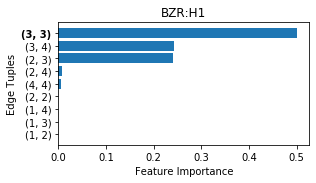

In [24]:
name = "BZR"
data_type='Discrete'
embed_type=2 #PWLR-OPT representation
entry_type=1 #PWLR-OPT-H1 representation
n_estimator_list = [10,25,50,100,150,200] #RF n_estimators
max_depth_list = [None]
parameter_list = [(2,0)] #values of k1 and k2
repeat_num=10 #number of iterations of 10-fold CV
grid_type = True #classification result obtained from grid search
feature_type = True #feature importance obtained from RF displayed (only applicable to embed_type=2 & entry_type=0,1)

result0, result1, result2 = grid_search_graph(name, entry_type, parameter_list, repeat_num, n_estimator_list, max_depth_list,data_type=data_type,embed_type=embed_type, grid_check=grid_type, feature_check=feature_type)

In [25]:
name = "BZR"
data_type='Discrete'
embed_type=2 #PWLR-OPT representation
entry_type=2 #PWLR-OPT-H0+H1 representation
n_estimator_list = [10,25,50,100,150,200] #RF n_estimators
max_depth_list = [None]
parameter_list = [(11,3)] #values of k1 and k2
repeat_num=10 #number of iterations of 10-fold CV
grid_type = True #classification result obtained from grid search
feature_type = False #feature importance obtained from RF displayed (only applicable to embed_type=2 & entry_type=0,1)

result0, result1, result2 = grid_search_graph(name, entry_type, parameter_list, repeat_num, n_estimator_list, max_depth_list,data_type=data_type,embed_type=embed_type, grid_check=grid_type, feature_check=feature_type)

 11 and 3
---10 Iterations of 10-fold CV---
0.876380550343965
0.8941979362101314
0.8838836772983114
0.9034568480300189
0.8844418386491556
0.8986522826766729
0.8988930581613509
0.9015181363352095
0.8938289555972483
0.8962679799874922
---Results---
H0+H1 0.8931521263289556 0.008328906356904767


# BZR (Discrete & Continuous)

### BZR PWLR

In [26]:
name = "BZR"
data_type='Continuous'
embed_type=1 #PWLR representation
entry_type=0 #PWLR-H0 representation
n_estimator_list = [10,25,50,100,150,200] #RF n_estimators
max_depth_list = [None]
parameter_list = [(25,1)] #values of k1 and k2
repeat_num=10 #number of iterations of 10-fold CV
grid_type = True #classification result obtained from grid search
feature_type = False #feature importance obtained from RF displayed (only applicable to embed_type=2 & entry_type=0,1)

result0, result1, result2 = grid_search_graph(name, entry_type, parameter_list, repeat_num, n_estimator_list, max_depth_list,data_type=data_type,embed_type=embed_type, grid_check=grid_type, feature_check=feature_type)

 25 and 1
---10 Iterations of 10-fold CV---
0.8790697310819263
0.871749530956848
0.8790697310819262
0.8788227016885554
0.8793808630393997
0.8812038774233896
0.8816948092557848
0.8793261413383364
0.8746247654784239
0.8765056285178238
---Results---
H0 0.8781447779862415 0.0028815183083918377


In [27]:
name = "BZR"
data_type='Continuous'
embed_type=1 #PWLR representation
entry_type=1 #PWLR-H1 representation
n_estimator_list = [10,25,50,100,150,200] #RF n_estimators
max_depth_list = [None]
parameter_list = [(24,10)] #values of k1 and k2
repeat_num=10 #number of iterations of 10-fold CV
grid_type = True #classification result obtained from grid search
feature_type = False #feature importance obtained from RF displayed (only applicable to embed_type=2 & entry_type=0,1)

result0, result1, result2 = grid_search_graph(name, entry_type, parameter_list, repeat_num, n_estimator_list, max_depth_list,data_type=data_type,embed_type=embed_type, grid_check=grid_type, feature_check=feature_type)

 24 and 10
---10 Iterations of 10-fold CV---
0.8668777360850533
0.8793167604752972
0.8812585991244528
0.8640056285178236
0.8796216385240776
0.8691307066916822
0.8787617260787991
0.8768839899937462
0.8693808630393995
0.8639383989993746
---Results---
H1 0.8729176047529705 0.0065477478922076745


In [28]:
name = "BZR"
data_type='Continuous'
embed_type=1 #PWLR representation
entry_type=2 #PWLR-H0+H1 representation
n_estimator_list = [10,25,50,100,150,200] #RF n_estimators
max_depth_list = [None]
parameter_list = [(22,1)] #values of k1 and k2
repeat_num=10 #number of iterations of 10-fold CV
grid_type = True #classification result obtained from grid search
feature_type = False #feature importance obtained from RF displayed (only applicable to embed_type=2 & entry_type=0,1)

result0, result1, result2 = grid_search_graph(name, entry_type, parameter_list, repeat_num, n_estimator_list, max_depth_list,data_type=data_type,embed_type=embed_type, grid_check=grid_type, feature_check=feature_type)

 22 and 1
---10 Iterations of 10-fold CV---
0.8788836772983114
0.8768136335209507
0.886447779862414
0.8863868042526578
0.869624765478424
0.8812679799874921
0.8840728580362727
0.8742651657285803
0.8771278924327705
0.871688555347092
---Results---
H0+H1 0.8786579111944965 0.00558400477468644


### BZR PWLR-OPT

 29 and 10
---10 Iterations of 10-fold CV---
0.8885178236397749
0.89432301438399
0.8865087554721702
0.8812007504690431
0.8841916823014383
0.8815181363352096
0.8763227016885553
0.8841400875547217
0.8793808630393997
0.8791916823014384
---Results---
H0 0.8835295497185742 0.0049850280068141906
---Feature Importance---
['(1, 2)', 0.0297838086981188]
['(1, 3)', 0.15216721786741225]
['(1, 4)', 0.09772872442583687]
['(2, 2)', 0.00759053599603623]
['(2, 3)', 0.103627221912059]
['(2, 4)', 0.03789808903309052]
['(3, 3)', 0.28348661656183605]
['(3, 4)', 0.23192236546024425]
['(4, 4)', 0.0557954200453661]


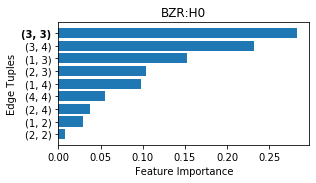

In [29]:
name = "BZR"
data_type='Continuous'
embed_type=2 #PWLR-OPT representation
entry_type=0 #PWLR-OPT-H0 representation
n_estimator_list = [10,25,50,100,150,200] #RF n_estimators
max_depth_list = [None]
parameter_list = [(29,10)] #values of k1 and k2
repeat_num=10 #number of iterations of 10-fold CV
grid_type = True #classification result obtained from grid search
feature_type = True #feature importance obtained from RF displayed (only applicable to embed_type=2 & entry_type=0,1)

result0, result1, result2 = grid_search_graph(name, entry_type, parameter_list, repeat_num, n_estimator_list, max_depth_list,data_type=data_type,embed_type=embed_type, grid_check=grid_type, feature_check=feature_type)

 16 and 18
---10 Iterations of 10-fold CV---
0.8565634771732332
0.8644965603502189
0.8740056285178237
0.8638227016885553
0.8790666041275799
0.8713868042526579
0.8591916823014383
0.867063789868668
0.8494387116948093
0.8691885553470918
---Results---
H1 0.8654224515322075 0.008297500739368607
---Feature Importance---
['(1, 2)', 0.0]
['(1, 3)', 0.0]
['(1, 4)', 0.0]
['(2, 2)', 0.0]
['(2, 3)', 0.24637805971185536]
['(2, 4)', 0.1323643551683098]
['(3, 3)', 0.4263556995955149]
['(3, 4)', 0.1925700128849491]
['(4, 4)', 0.0023318726393708362]


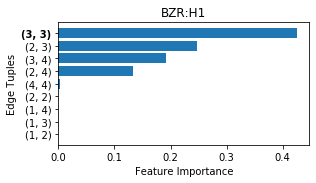

In [30]:
name = "BZR"
data_type='Continuous'
embed_type=2 #PWLR-OPT representation
entry_type=1 #PWLR-OPT-H1 representation
n_estimator_list = [10,25,50,100,150,200] #RF n_estimators
max_depth_list = [None]
parameter_list = [(16,18)] #values of k1 and k2
repeat_num=10 #number of iterations of 10-fold CV
grid_type = True #classification result obtained from grid search
feature_type = True #feature importance obtained from RF displayed (only applicable to embed_type=2 & entry_type=0,1)

result0, result1, result2 = grid_search_graph(name, entry_type, parameter_list, repeat_num, n_estimator_list, max_depth_list,data_type=data_type,embed_type=embed_type, grid_check=grid_type, feature_check=feature_type)

In [31]:
name = "BZR"
data_type='Continuous'
embed_type=2 #PWLR-OPT representation
entry_type=2 #PWLR-OPT-H0+H1 representation
n_estimator_list = [10,25,50,100,150,200] #RF n_estimators
max_depth_list = [None]
parameter_list = [(2,1)] #values of k1 and k2
repeat_num=10 #number of iterations of 10-fold CV
grid_type = True #classification result obtained from grid search
feature_type = False #feature importance obtained from RF displayed (only applicable to embed_type=2 & entry_type=0,1)

result0, result1, result2 = grid_search_graph(name, entry_type, parameter_list, repeat_num, n_estimator_list, max_depth_list,data_type=data_type,embed_type=embed_type, grid_check=grid_type, feature_check=feature_type)

 2 and 1
---10 Iterations of 10-fold CV---
0.8787617260787993
0.8868839899937461
0.8838868042526578
0.8934568480300188
0.8817526579111945
0.8884599749843651
0.8911976235146968
0.8867651657285803
0.8791338336460288
0.883886804252658
---Results---
H0+H1 0.8854185428392747 0.004616982774301009


# BZR-MD

### BZR-MD PWLR

In [32]:
name = "BZR_MD"
data_type='Discrete'
embed_type=1 #PWLR representation
entry_type=0 #PWLR-H0 representation
n_estimator_list = [10,25,50,100,150,200] #RF n_estimators
max_depth_list = [None]
parameter_list = [(0,3)] #values of k1 and k2
repeat_num=10 #number of iterations of 10-fold CV
grid_type = True #classification result obtained from grid search
feature_type = False #feature importance obtained from RF displayed (only applicable to embed_type=2 & entry_type=0,1)

result0, result1, result2 = grid_search_graph(name, entry_type, parameter_list, repeat_num, n_estimator_list, max_depth_list,data_type=data_type,embed_type=embed_type, grid_check=grid_type, feature_check=feature_type)

 0 and 3
---10 Iterations of 10-fold CV---
0.7641342232109751
0.7642417500926956
0.7318613274008157
0.7411012235817576
0.7576974416017798
0.7677827215424544
0.7322061549870227
0.7614534668149796
0.7394252873563218
0.7485576566555432
---Results---
H0 0.7508461253244345 0.01319404264489425


In [33]:
name = "BZR_MD"
data_type='Discrete'
embed_type=1 #PWLR representation
entry_type=1 #PWLR-H1 representation
n_estimator_list = [10,25,50,100,150,200] #RF n_estimators
max_depth_list = [None]
parameter_list = [(1,4)] #values of k1 and k2
repeat_num=10 #number of iterations of 10-fold CV
grid_type = True #classification result obtained from grid search
feature_type = False #feature importance obtained from RF displayed (only applicable to embed_type=2 & entry_type=0,1)

result0, result1, result2 = grid_search_graph(name, entry_type, parameter_list, repeat_num, n_estimator_list, max_depth_list,data_type=data_type,embed_type=embed_type, grid_check=grid_type, feature_check=feature_type)

 1 and 4
---10 Iterations of 10-fold CV---
0.771776047460141
0.7709158324063774
0.7671153133110864
0.79771227289581
0.781153133110864
0.7710085279940676
0.7875676677790138
0.7652317389692251
0.7846941045606228
0.7775824990730441
---Results---
H1 0.7774757137560253 0.00975500584668274


In [34]:
name = "BZR_MD"
data_type='Discrete'
embed_type=1 #PWLR representation
entry_type=2 #PWLR-H0+H1 representation
n_estimator_list = [10,25,50,100,150,200] #RF n_estimators
max_depth_list = [None]
parameter_list = [(2,1)] #values of k1 and k2
repeat_num=10 #number of iterations of 10-fold CV
grid_type = True #classification result obtained from grid search
feature_type = False #feature importance obtained from RF displayed (only applicable to embed_type=2 & entry_type=0,1)

result0, result1, result2 = grid_search_graph(name, entry_type, parameter_list, repeat_num, n_estimator_list, max_depth_list,data_type=data_type,embed_type=embed_type, grid_check=grid_type, feature_check=feature_type)

 2 and 1
---10 Iterations of 10-fold CV---
0.7544493882091212
0.7542343344456803
0.7583203559510567
0.7609158324063775
0.7454542083796811
0.7904783092324805
0.7753392658509455
0.755231738969225
0.7650018539117538
0.7841416388579904
---Results---
H0+H1 0.7643566926214312 0.013726902362255274


### BZR_MD PWLR-OPT

 1 and 1
---10 Iterations of 10-fold CV---
0.7346644419725621
0.7348720800889879
0.708735632183908
0.7119836855765665
0.7289877641824248
0.7386725991842789
0.7358694846125325
0.6926140155728586
0.7288654060066742
0.732220986281053
---Results---
H0 0.7247486095661847 0.014356550613578354
---Feature Importance---
['(1, 2)', 0.07985606327833543]
['(1, 3)', 0.1825713662623249]
['(1, 4)', 0.015568439971019296]
['(2, 2)', 0.21935024027532685]
['(2, 3)', 0.2563356831671202]
['(2, 4)', 0.017434171896772623]
['(3, 3)', 0.20704099546819155]
['(3, 4)', 0.02184303968090916]


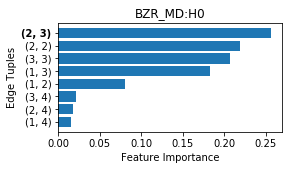

In [39]:
name = "BZR_MD"
data_type='Discrete'
embed_type=2 #PWLR-OPT representation
entry_type=0 #PWLR-OPT-H0 representation
n_estimator_list = [10,25,50,100,150,200] #RF n_estimators
max_depth_list = [None]
parameter_list = [(1,1)] #values of k1 and k2
repeat_num=10 #number of iterations of 10-fold CV
grid_type = True #classification result obtained from grid search
feature_type = True #feature importance obtained from RF displayed (only applicable to embed_type=2 & entry_type=0,1)

result0, result1, result2 = grid_search_graph(name, entry_type, parameter_list, repeat_num, n_estimator_list, max_depth_list,data_type=data_type,embed_type=embed_type, grid_check=grid_type, feature_check=feature_type)

 2 and 0
---10 Iterations of 10-fold CV---
0.7374378939562477
0.7380830552465703
0.7352020763811643
0.7503411197626992
0.7480126065999259
0.7446496106785317
0.7556618464961068
0.751783463107156
0.7118539117538005
0.7453170189099
---Results---
H1 0.7418342602892103 0.011819432903416143
---Feature Importance---
['(1, 2)', 0.0]
['(1, 3)', 0.0]
['(1, 4)', 0.0]
['(2, 2)', 0.12231865084366075]
['(2, 3)', 0.5948692178035972]
['(2, 4)', 0.0]
['(3, 3)', 0.26348741193448777]
['(3, 4)', 0.019324719418254276]


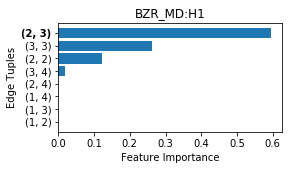

In [36]:
name = "BZR_MD"
data_type='Discrete'
embed_type=2 #PWLR-OPT representation
entry_type=1 #PWLR-OPT-H1 representation
n_estimator_list = [10,25,50,100,150,200] #RF n_estimators
max_depth_list = [None]
parameter_list = [(2,0)] #values of k1 and k2
repeat_num=10 #number of iterations of 10-fold CV
grid_type = True #classification result obtained from grid search
feature_type = True #feature importance obtained from RF displayed (only applicable to embed_type=2 & entry_type=0,1)

result0, result1, result2 = grid_search_graph(name, entry_type, parameter_list, repeat_num, n_estimator_list, max_depth_list,data_type=data_type,embed_type=embed_type, grid_check=grid_type, feature_check=feature_type)

In [43]:
name = "BZR_MD"
data_type='Discrete'
embed_type=2 #PWLR-OPT representation
entry_type=2 #PWLR-OPT-H0+H1 representation
n_estimator_list = [10,25,50,100,150,200] #RF n_estimators
max_depth_list = [None]
parameter_list = [(0,11)] #values of k1 and k2
repeat_num=10 #number of iterations of 10-fold CV
grid_type = True #classification result obtained from grid search
feature_type = False #feature importance obtained from RF displayed (only applicable to embed_type=2 & entry_type=0,1)

result0, result1, result2 = grid_search_graph(name, entry_type, parameter_list, repeat_num, n_estimator_list, max_depth_list,data_type=data_type,embed_type=embed_type, grid_check=grid_type, feature_check=feature_type)

 0 and 11
---10 Iterations of 10-fold CV---
0.7451019651464591
0.7676826103077493
0.7476603633667038
0.7575899147200593
0.7651316277345198
0.7614460511679644
0.7622135706340378
0.7355469039673712
0.7445569150908418
0.7680051909529106
---Results---
H0+H1 0.7554935113088617 0.010815799115764831
